### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/no_upper_exposure_limits/alabama/2023_07_13_10_32_43/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/no_upper_exposure_limits/alabama/2023_07_13_10_32_43/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,Female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,Female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0
2,2,Female,2023,acute_ischemic_stroke,deaths,29,baseline,35_to_39,0
3,3,Female,2023,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0
4,4,Female,2023,acute_ischemic_stroke,deaths,29,baseline,45_to_49,0


In [5]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

6613292.287474332

### Total DALYs by Year

In [6]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,Female,25_to_29,29,2023,61.009084,4.021410,65.030493
1,Female,25_to_29,29,2024,309.909287,5.211611,315.120898
2,Female,25_to_29,29,2025,0.000000,5.838734,5.838734
3,Female,25_to_29,29,2026,63.733246,6.644620,70.377867
4,Female,25_to_29,29,2027,59.384492,6.944942,66.329434


In [7]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,420.743851,47.767633,923.445023
1,2024,408.366643,45.585684,951.992866
2,2025,422.352076,44.690478,949.951209
3,2026,425.382811,52.654813,974.807011
4,2027,405.932688,44.911369,881.607596


### All Cause Mortality Graphs

In [8]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.2625,0.0,2.000
1,25_to_29,Female,2024,0.3875,0.0,3.000
2,25_to_29,Female,2025,0.2250,0.0,2.000
3,25_to_29,Female,2026,0.4000,0.0,2.025
4,25_to_29,Female,2027,0.2500,0.0,2.000


#### All Cause Mortality Graph with Rate

In [9]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,Female,2023,29,1832.093087
1,25_to_29,Female,2023,232,1769.308693
2,25_to_29,Female,2023,357,1778.891170
3,25_to_29,Female,2023,394,1746.694045
4,25_to_29,Female,2023,602,1771.378508


In [10]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.001201,0.000123,0.003548
1,25_to_29,Female,2024,0.001769,0.000000,0.004246
2,25_to_29,Female,2025,0.001036,0.000000,0.002640
3,25_to_29,Female,2026,0.001844,0.000685,0.003643
4,25_to_29,Female,2027,0.001154,0.000000,0.002724


### Cause Specific Mortality Graphs
#### Acute Stroke

In [11]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,Female,2023,acute_ischemic_stroke,0.0,0.0,0.000
1,8,25_to_29,Female,2024,acute_ischemic_stroke,0.3,0.0,1.775
2,16,25_to_29,Female,2025,acute_ischemic_stroke,0.0,0.0,0.000
3,24,25_to_29,Female,2026,acute_ischemic_stroke,0.1,0.0,0.775
4,32,25_to_29,Female,2027,acute_ischemic_stroke,0.0,0.0,0.000


In [12]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,Female,2023,29,acute_ischemic_stroke,0
1,8,25_to_29,Female,2023,232,acute_ischemic_stroke,0
2,16,25_to_29,Female,2023,357,acute_ischemic_stroke,0
3,24,25_to_29,Female,2023,394,acute_ischemic_stroke,0
4,32,25_to_29,Female,2023,602,acute_ischemic_stroke,0


In [13]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.0,0.000000
1,25_to_29,Female,2024,0.000169,0.0,0.000986
2,25_to_29,Female,2025,0.000000,0.0,0.000000
3,25_to_29,Female,2026,0.000058,0.0,0.000448
4,25_to_29,Female,2027,0.000000,0.0,0.000000


#### Chronic Stroke

In [14]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.0,0.000000
1,25_to_29,Female,2024,0.000000,0.0,0.000000
2,25_to_29,Female,2025,0.000000,0.0,0.000000
3,25_to_29,Female,2026,0.000000,0.0,0.000000
...,...,...,...,...,...,...
536,95_plus,Male,2037,0.007661,0.0,0.044108
537,95_plus,Male,2038,0.002523,0.0,0.019554
538,95_plus,Male,2039,0.000000,0.0,0.000000
539,95_plus,Male,2040,0.020301,0.0,0.054956


#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [15]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000201,0.0,0.001762
1,25_to_29,Female,2024,0.000314,0.0,0.002031
2,25_to_29,Female,2025,0.000116,0.0,0.000583
3,25_to_29,Female,2026,0.000348,0.0,0.001750
4,25_to_29,Female,2027,0.000144,0.0,0.000890


#### Post Myocaridal Infarction

In [16]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.0,0.000000
1,25_to_29,Female,2024,0.000173,0.0,0.001030
2,25_to_29,Female,2025,0.000173,0.0,0.001029
3,25_to_29,Female,2026,0.000057,0.0,0.000445
4,25_to_29,Female,2027,0.000171,0.0,0.000583


#### Heart Failure

In [17]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000227,0.0,0.001140
1,25_to_29,Female,2024,0.000201,0.0,0.001187
2,25_to_29,Female,2025,0.000201,0.0,0.001157
3,25_to_29,Female,2026,0.000201,0.0,0.000885
4,25_to_29,Female,2027,0.000146,0.0,0.000890


### Excess Mortality rate

#### Post Myocardial Infarction

In [19]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.0,0.000000
1,25_to_29,Female,2024,0.032786,0.0,0.168171
2,25_to_29,Female,2025,0.030103,0.0,0.168075
3,25_to_29,Female,2026,0.012078,0.0,0.086964
4,25_to_29,Female,2027,0.051776,0.0,0.313923


#### Heart Failure EMR

In [22]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [23]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,inf,0.0,NaN
1,25_to_29,Female,2024,inf,0.0,NaN
2,25_to_29,Female,2025,inf,0.0,NaN
3,25_to_29,Female,2026,inf,0.0,NaN
4,25_to_29,Female,2027,inf,0.0,NaN


### Prevalence 

#### Chronic + Acute Stroke

In [24]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000158,0.0,0.000642
1,25_to_29,Female,2024,0.000116,0.0,0.000563
2,25_to_29,Female,2025,0.000138,0.0,0.000844
3,25_to_29,Female,2026,0.000139,0.0,0.000716
4,25_to_29,Female,2027,0.000137,0.0,0.000672


In [25]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

#### Myocardial Infarction

In [26]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000087,0.0,0.000326
1,25_to_29,Female,2024,0.000158,0.0,0.000297
2,25_to_29,Female,2025,0.000128,0.0,0.000492
3,25_to_29,Female,2026,0.000119,0.0,0.000253
4,25_to_29,Female,2027,0.000137,0.0,0.000311


In [27]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.002776,0.001301,0.005682
1,25_to_29,Female,2024,0.003184,0.000754,0.006989
2,25_to_29,Female,2025,0.003466,0.000369,0.007610
3,25_to_29,Female,2026,0.003773,0.000106,0.008349
4,25_to_29,Female,2027,0.004153,0.000401,0.009062


In [29]:
tran = pd.read_csv(sim_results_dir + '/transition_count.csv')
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_post_hf = person_time.loc[(person_time['state'].isin(['post_myocardial_infarction']))].reset_index()
tran_rate_post_to_hf = tran.loc[(tran['transition'].isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_post_to_hf = tran_rate_post_to_hf.groupby(groupby_cols).sum() / per_time_sus_post_hf.groupby(groupby_cols).sum()
tran_rate_post_to_hf_summ = (tran_rate_post_to_hf.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_post_to_hf_summ#.head()

mean  2.5%     97.5%
age      sex    year                          
25_to_29 Female 2023  0.000000   0.0  0.000000
                2024  0.000000   0.0  0.000000
                2025  0.000000   0.0  0.000000
                2026  0.000000   0.0  0.000000
...                        ...   ...       ...
95_plus  Male   2037  0.497313   0.0  3.440590
                2038  0.142891   0.0  0.475156
                2039  0.173930   0.0  0.568233
                2040  0.146457   0.0  0.486666

[540 rows x 3 columns]

In [30]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_ami_post = person_time.loc[(person_time['state'].isin(['acute_myocardial_infarction']))].reset_index()
tran_rate_ami_to_post = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_to_post_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_ami_to_post = tran_rate_ami_to_post.groupby(groupby_cols).sum() / tran_rate_ami_to_post.groupby(groupby_cols).sum()
tran_rate_ami_to_post_summ = (tran_rate_ami_to_post.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_ami_to_post_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 Female 2023   1.0   1.0    1.0
                2024   1.0   1.0    1.0
                2025   1.0   1.0    1.0
                2026   1.0   1.0    1.0
                2027   1.0   1.0    1.0

### Prevalence of Heart Failure

In [31]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.001347,0.0,0.004701
1,25_to_29,Female,2024,0.001424,0.0,0.004775
2,25_to_29,Female,2025,0.001530,0.0,0.004402
3,25_to_29,Female,2026,0.001648,0.0,0.005161
4,25_to_29,Female,2027,0.001787,0.0,0.006328


### Incidence of First Time Acute Ischemic Stroke

In [32]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,10,25_to_29,Female,2023,susceptible_to_ischemic_stroke_to_acute_ischem...,1.6,0.0,4.775
1,21,25_to_29,Female,2024,susceptible_to_ischemic_stroke_to_acute_ischem...,0.7,0.0,2.775
2,32,25_to_29,Female,2025,susceptible_to_ischemic_stroke_to_acute_ischem...,1.0,0.0,5.325
3,43,25_to_29,Female,2026,susceptible_to_ischemic_stroke_to_acute_ischem...,1.2,0.0,4.325
4,54,25_to_29,Female,2027,susceptible_to_ischemic_stroke_to_acute_ischem...,0.7,0.0,2.775


In [33]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,80,25_to_29,Female,2023,susceptible_to_ischemic_stroke,29,1812.008214
1,81,25_to_29,Female,2023,susceptible_to_ischemic_stroke,232,1760.032854
2,82,25_to_29,Female,2023,susceptible_to_ischemic_stroke,357,1758.499658
3,83,25_to_29,Female,2023,susceptible_to_ischemic_stroke,394,1731.055441
4,84,25_to_29,Female,2023,susceptible_to_ischemic_stroke,602,1757.733060


In [35]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000897,0.0,0.002693
1,25_to_29,Female,2024,0.000395,0.0,0.001536
2,25_to_29,Female,2025,0.000568,0.0,0.002985
3,25_to_29,Female,2026,0.000684,0.0,0.002435
4,25_to_29,Female,2027,0.000403,0.0,0.001595


### Incidence of Acute Myocardial Infraction 

In [36]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI_HF = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure']))].reset_index()

In [37]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction','susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean  2.5%     97.5%
age      sex    year                          
25_to_29 Female 2023  0.001199   0.0  0.004273
                2024  0.001900   0.0  0.003757
                2025  0.001795   0.0  0.006583
                2026  0.001562   0.0  0.003761
                2027  0.001795   0.0  0.003925

### Incidence of Heart Failure 

In [38]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean  2.5%     97.5%
age      sex    year                          
25_to_29 Female 2023  0.000741   0.0  0.002024
                2024  0.000630   0.0  0.001168
                2025  0.000690   0.0  0.001164
                2026  0.000865   0.0  0.002193
                2027  0.000869   0.0  0.002204

### Artifacts

In [39]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/

Alabama.hdf           alabama.hdf  v1-20230613/
alabama-BAD-PAFS.hdf  test/        washington.hdf


In [40]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [41]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [42]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [47]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [48]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [45]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.001437,0.000000,0.003625
1,25_to_29,Male,0.002700,0.000579,0.005901
2,30_to_34,Female,0.001590,0.000000,0.004100
3,30_to_34,Male,0.002529,0.000559,0.005045
4,35_to_39,Female,0.001642,0.000000,0.004039


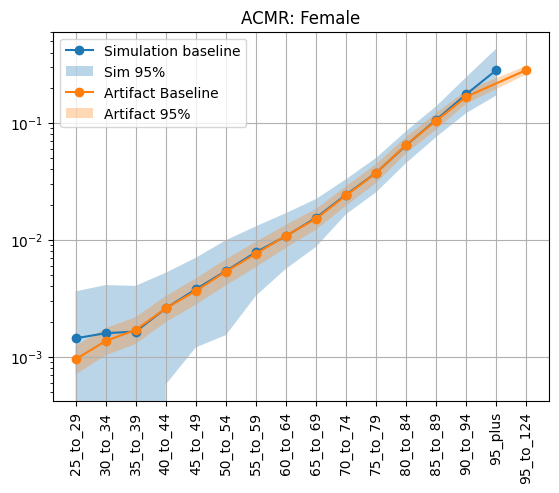

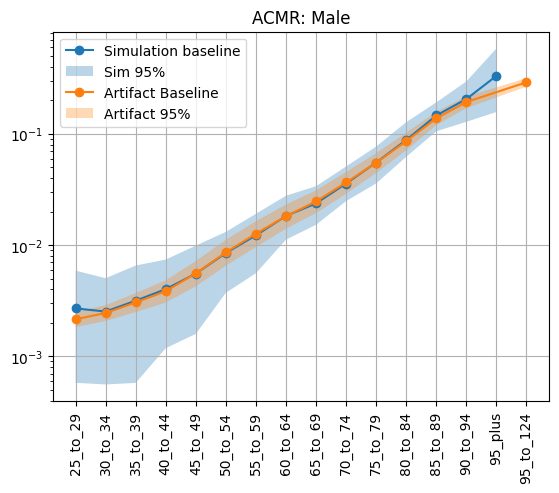

In [49]:
with PdfPages('model12_acmr_artifact_and_sim.pdf') as pdf:
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [50]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [51]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [52]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [53]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [54]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000049,0.0,0.000618
1,25_to_29,Male,0.000007,0.0,0.000000
2,30_to_34,Female,0.000019,0.0,0.000298
3,30_to_34,Male,0.000003,0.0,0.000000
4,35_to_39,Female,0.000016,0.0,0.000303


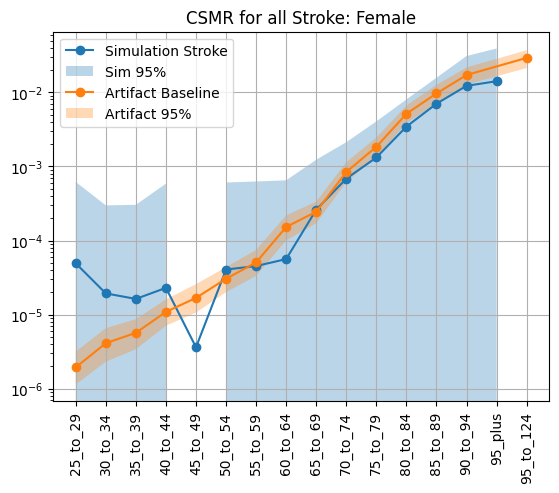

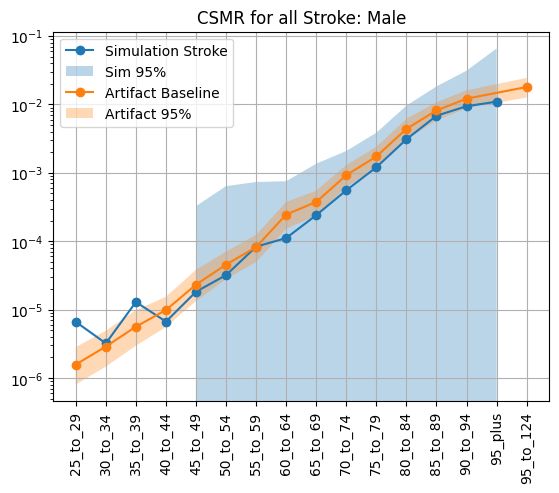

In [55]:
with PdfPages('model12_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        #subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        #plt.plot(subdata['age'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        #subdata2 = chronic_rate_allyear.loc[(chronic_rate_allyear.sex==sex)]
        #plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        #plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### IHD and HF Combined

In [ ]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

In [ ]:
death_rate_cause.cause.unique()

In [ ]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear

In [ ]:
for sex in IHD_HF_CSMR_allyear.sex.unique():
    plt.figure() 
    subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for IHD and HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [56]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [57]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, 0.5, .975])
                 .filter(['50%', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,year,50%,2.5%,97.5%
0,25_to_29,Female,2023,0.000565,0.0,0.002693
1,25_to_29,Female,2024,0.000000,0.0,0.001536
2,25_to_29,Female,2025,0.000000,0.0,0.002985
3,25_to_29,Female,2026,0.000279,0.0,0.002435
4,25_to_29,Female,2027,0.000000,0.0,0.001595


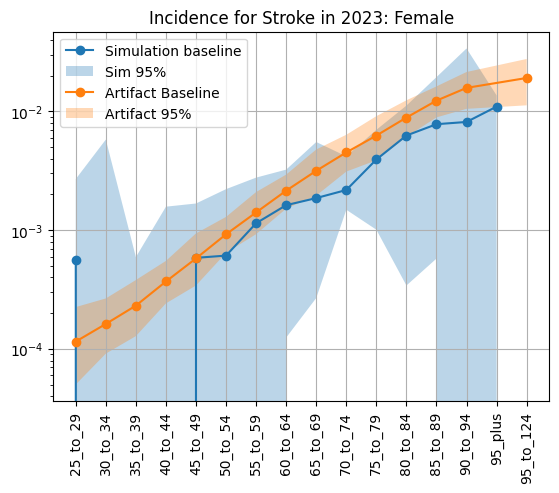

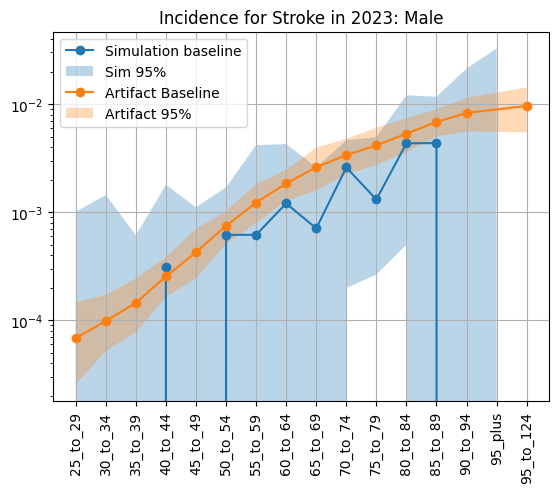

In [58]:
with PdfPages('model12_inc_artifact_and_sim.pdf') as pdf:
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2023)]
        plt.plot(subdata['age'], subdata['50%'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke in 2023: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

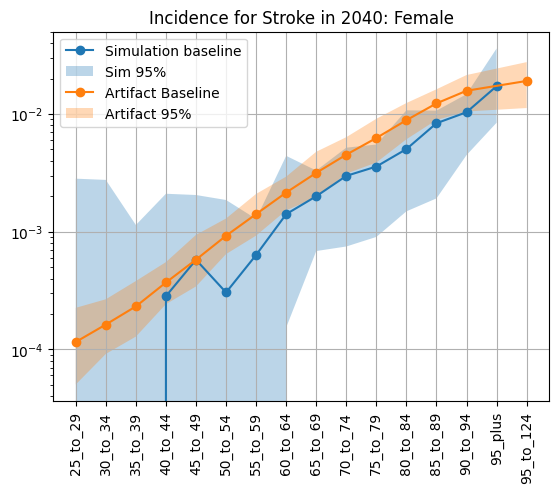

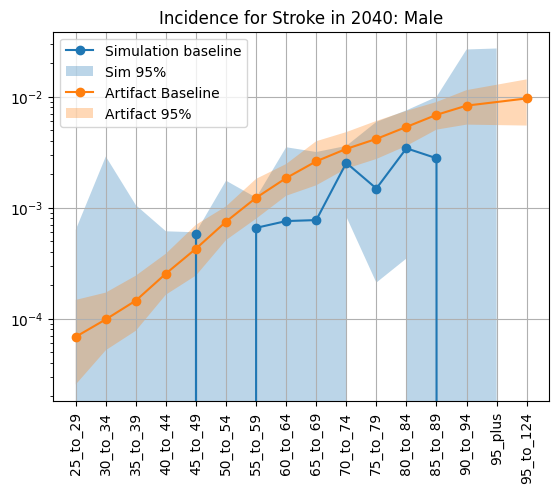

In [59]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke in 2040: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [60]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000453,0.000285,0.000617,Alabama,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000512,0.000347,0.000685,Alabama,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000428,0.000297,0.000583,Alabama,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000541,0.000415,0.000692,Alabama,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000853,0.000652,0.001114,Alabama,incidence_rate,45_to_49


In [61]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_HF = tran_rate_MI_HF.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_rate_MI_HF = (tran_rate_MI_HF.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_rate_MI_HF.head()

mean  50%  2.5%     97.5%
age      sex                                  
25_to_29 Female  0.000000  0.0   0.0  0.000000
         Male    0.000000  0.0   0.0  0.000000
30_to_34 Female  0.000000  0.0   0.0  0.000000
         Male    0.000000  0.0   0.0  0.000000
35_to_39 Female  0.000003  0.0   0.0  0.000025

In [62]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean       50%      2.5%     97.5%
age      sex                                           
25_to_29 Female  0.001569  0.001099  0.000103  0.003971
         Male    0.001209  0.000535  0.000036  0.003452
30_to_34 Female  0.001221  0.000956  0.000104  0.003858
         Male    0.001388  0.001007  0.000199  0.004798
35_to_39 Female  0.000616  0.000563  0.000284  0.001099

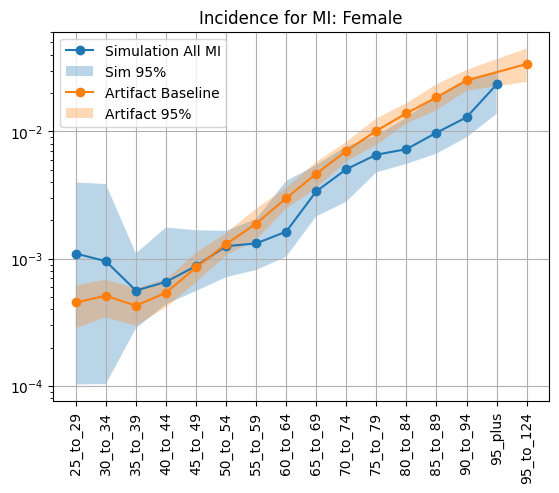

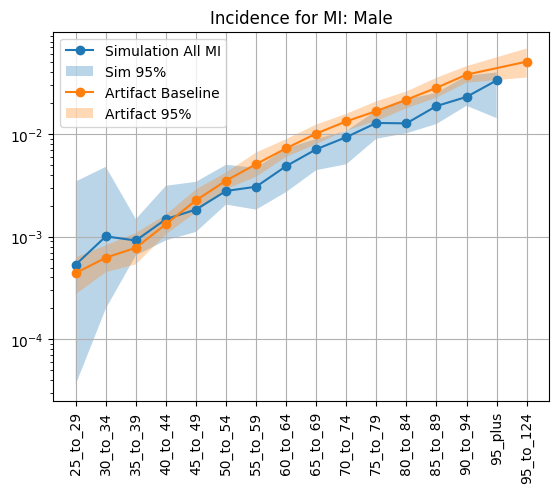

In [63]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure IHD

In [ ]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

In [ ]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear.head()

In [ ]:
for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [ ]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

In [ ]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear.head()

In [ ]:
for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF Resid: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [ ]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [ ]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

In [ ]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [ ]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [ ]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

In [ ]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [ ]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

In [ ]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

In [ ]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex) & (prev_post_MI_sum_allyear.year == 2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [ ]:
## 2023 looks pretty good but 2040 looks pretty bad 

#### Prevalence of Acute MI

In [ ]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

In [ ]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

In [ ]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [ ]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

In [ ]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear.head()

In [ ]:
for sex in prev_HF_IHD_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [ ]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

In [ ]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_resid_allyear.head()

In [ ]:
for sex in prev_HF_resid_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF Residual: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [ ]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

In [ ]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

In [ ]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [ ]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [ ]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

In [ ]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [ ]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [ ]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','ptvalue']], on=['age','year','sex','input_draw'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear.head()

In [ ]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex) & (acute_MI_emr_rate_allyear.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [ ]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

In [ ]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

In [ ]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### EMR for Heart Failure

In [ ]:
art_emr_HF = load_artifact_data('cause', 'heart_failure', 'excess_mortality_rate')
art_emr_HF['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_HF.age_start,art_emr_HF.age_end)]
art_emr_HF.head()

In [ ]:
HF_emr_allyear = (HF_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025,0.5, .975])
                      .filter(['mean','50%', '2.5%', '97.5%'])
                      .reset_index())


HF_emr_allyear.head()

In [ ]:
for sex in HF_emr_allyear.sex.unique():
    plt.figure() 
    subdata = HF_emr_allyear.loc[(HF_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_HF.loc[(art_emr_HF.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Looks a little wild in the youngest age groups but I think this is likely just due to very small sample sizes 

When I changed it to the median it matches exactly